# Inference Time Baby 😎

In [1]:
import random
from pathlib import Path
from types import SimpleNamespace

import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'gray_r'

import wandb

In [2]:
dataset_at = 'capecape/gtc/np_dataset:v1'
model_at = 'capecape/ddpm_clouds/io88jpwg_ddpm_uvit:v0'

## Grab the Dataset

In [3]:
with wandb.init(project="ddpm_clouds"):
    artifact = wandb.use_artifact(dataset_at, type='dataset')
    dataset_dir = Path(artifact.download())

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: capecape. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact np_dataset:v1, 7633.24MB. 60 files... 
wandb:   60 of 60 files downloaded.  
Done. 0:0:0.0


## Grab the trained Model

In [4]:
with wandb.init(project="ddpm_clouds"):
    artifact = wandb.use_artifact(model_at, type='model')
    model_dir = Path(artifact.download())

wandb: Downloading large artifact io88jpwg_ddpm_uvit:v0, 4312.58MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.0


## everything together

In [5]:
import math

import torch
from torch import sqrt
import torch.nn as nn
from torch.special import expm1

from fastprogress import progress_bar

from einops import rearrange, repeat, reduce, pack, unpack
from denoising_diffusion_pytorch.simple_diffusion import UViT
from clouds import CloudDataset, ls

from torch_moving_mnist.utils import *

In [6]:
config = SimpleNamespace(
    img_size=512,
    device="cuda:0",
)

In [7]:
files = ls(Path(dataset_dir))
valid_ds = CloudDataset(files[-3:], valid=True, size=config.img_size)

In [8]:
model = UViT(512,
             ff_mult=2,
             vit_depth=4,
             channels=4, 
             patch_size=4,
             final_img_itransform=nn.Conv2d(4,1,1))

load checkpoint

In [9]:
model.load_state_dict(torch.load(list(model_dir.glob("*.pth"))[0]))

<All keys matched successfully>

In [10]:
model = model.to(config.device)

## Sampling

In [11]:
def describe(img):
    print(  f"Image of type: {type(img)}\n"
            f"data type:     {img.dtype}\n"
            f"shape:         {img.shape}\n"
            f"min:           {img.min()}\n"
            f"max:           {img.max()}\n")

In [12]:
def log(t, eps = 1e-20):
    return torch.log(t.clamp(min = eps))

def logsnr_schedule_cosine(t, logsnr_min = -15, logsnr_max = 15):
    t_min = math.atan(math.exp(-0.5 * logsnr_max))
    t_max = math.atan(math.exp(-0.5 * logsnr_min))
    return -2 * log(torch.tan(t_min + t * (t_max - t_min)))

@torch.no_grad()
def forward(past_frames, x, t):
    return model(torch.cat([past_frames, x], dim=1), t)

def p_mean_variance(past_frames, x, time, time_next, pred_objective="v"):
    
    log_snr = logsnr_schedule_cosine(time)
    log_snr_next = logsnr_schedule_cosine(time_next)
    c = -expm1(log_snr - log_snr_next)

    squared_alpha, squared_alpha_next = log_snr.sigmoid(), log_snr_next.sigmoid()
    squared_sigma, squared_sigma_next = (-log_snr).sigmoid(), (-log_snr_next).sigmoid()

    alpha, sigma, alpha_next = map(sqrt, (squared_alpha, squared_sigma, squared_alpha_next))

    batch_log_snr = repeat(log_snr, ' -> b', b = x.shape[0])
    
    # forward pass (this is expensive)
    pred = forward(past_frames, x, batch_log_snr)

    if pred_objective == 'v':
        x_start = alpha * x - sigma * pred
    elif pred_objective == 'eps':
        x_start = (x - sigma * pred) / alpha

    x_start.clamp_(-1., 1.)

    model_mean = alpha_next * (x * (1 - c) / alpha + c * x_start)

    posterior_variance = squared_sigma_next * c

    return model_mean, posterior_variance

In [18]:
def p_sample(past_frames, x, time, time_next):
    batch, *_, device = *x.shape, x.device

    model_mean, model_variance = p_mean_variance(past_frames, x = x, time = time, time_next = time_next)

    if time_next == 0:
        return model_mean

    noise = torch.randn_like(x)
    return model_mean + sqrt(model_variance) * noise

def p_sample_loop(xt, num_sample_steps=500, device=config.device):
    past_frames = xt
    new_frame = torch.randn_like(xt[:,-1:], dtype=xt.dtype, device=device)
    steps = torch.linspace(1., 0., num_sample_steps + 1, device = device)

    for i in progress_bar(range(num_sample_steps), total = num_sample_steps):
        times = steps[i]
        times_next = steps[i + 1]
        new_frame = p_sample(past_frames, new_frame, time=times, time_next=times_next)

    new_frame.clamp_(-1., 1.)
    return new_frame

## Inference

In [19]:
len(valid_ds)

278

torch.Size([1, 4, 512, 512])


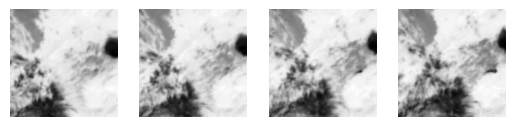

In [20]:
idx = 220

x0 = valid_ds[idx:idx+1].to(config.device)
print(x0.shape)
show_images(x0.squeeze())

In [21]:
describe(x0)

Image of type: <class 'torch.Tensor'>
data type:     torch.float32
shape:         torch.Size([1, 4, 512, 512])
min:           -0.42759907245635986
max:           0.3712269067764282



In [24]:
simple_preds = p_sample_loop(x0[:,:-1,...]).squeeze()

<AxesSubplot: >

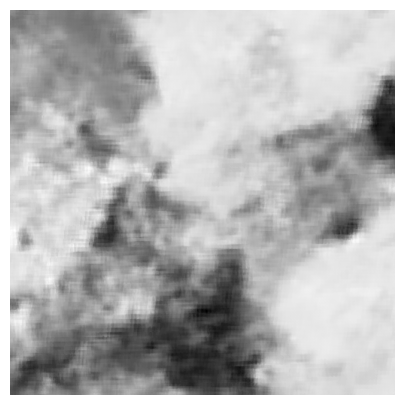

In [25]:
show_image(simple_preds)

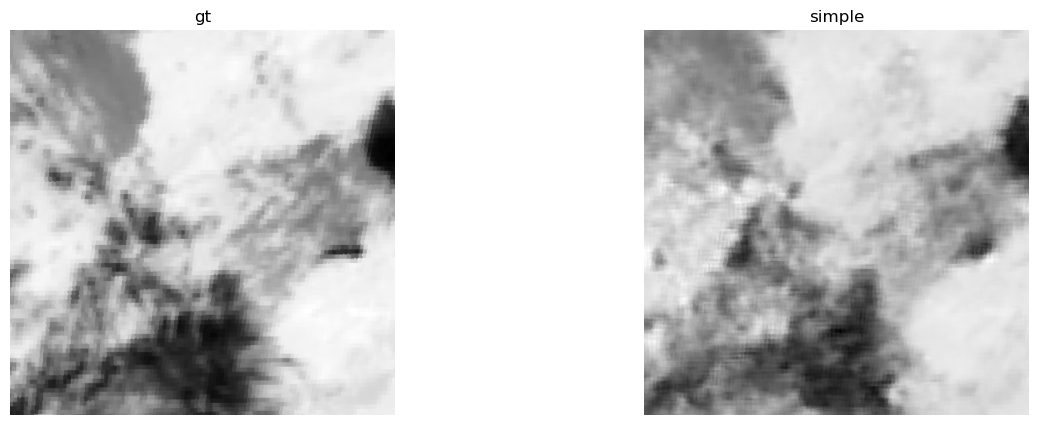

In [26]:
images = [x0[:,-1,...].squeeze(), simple_preds]
titles = ["gt", "simple"]
show_images(images, titles=titles, figsize=(15,5))

In [29]:
def htile(img):
    return torch.cat(img.split(1), dim=-1)

def vtile(img):
    return torch.cat(img.split(1), dim=-2)

def vhtile(*imgs):
    return vtile(torch.cat([htile(img) for img in imgs], dim=0))

## Sampler more timesteps

In [30]:
N = 2

In [32]:
def sample_more(frames, n=1):
    "Autoregressive sampling"
    for _ in progress_bar(range(n), total=n):
        new_frame = p_sample_loop(frames[:,-3:,...])
        frames = torch.cat([frames, new_frame.to(frames.device)], dim=1)
    return frames.cpu()

In [33]:
frames = sample_more(x0, n=N)

Samples

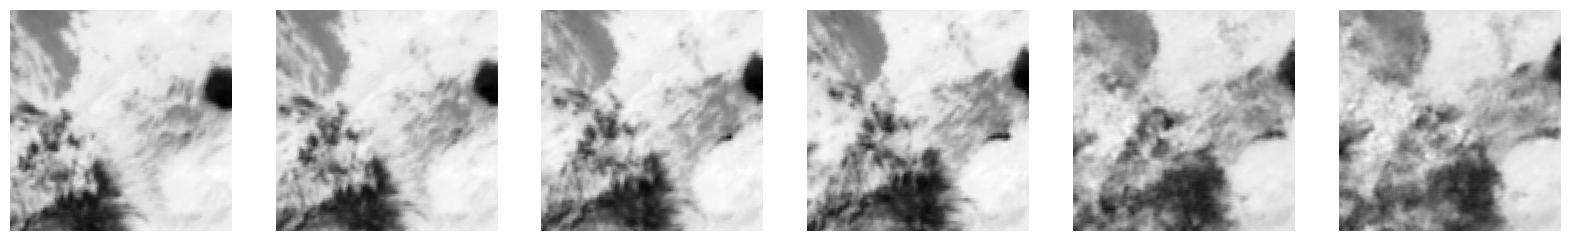

In [34]:
show_images(frames.squeeze(), figsize=(20,10))

GT

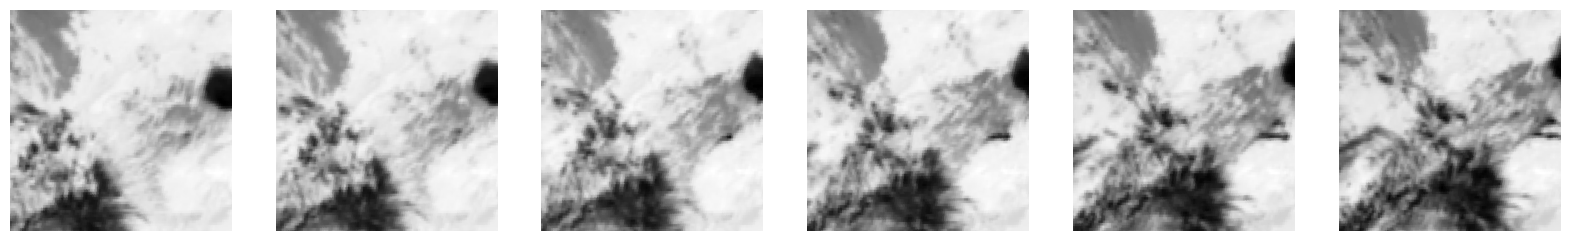

In [35]:
show_images(valid_ds[idx:idx+4+N,0,...], figsize=(20,10))

In [36]:
import numpy as np

def scale(arr):
    "Scales values of array in [0,1]"
    m, M = arr.min(), arr.max()
    return (arr - m) / (M - m)

def preprocess_frames(data):
    sdata = scale(data.squeeze())
    # print(sdata.shape)
    def tfm(frame):
        rframe = 255 * frame
        return rframe.cpu().numpy().astype(np.uint8)
    return [tfm(frame) for frame in sdata]

def to_video(data):
    "create wandb.Video container"
    frames = preprocess_frames(data)
    vid = np.stack(frames)[:, None, ...]
    return wandb.Video(vid)

## Different Noises produce different outputs:
If we generate the same sequence multiple times, we will get different diffusions, let's check that

In [37]:
config = SimpleNamespace(
    N = 10,  # number of future frames
    bs = 10, # how many samples
    num_random_experiments = 3, # we will perform inference multiple times on the same inputs
    seed=42,
    device="cuda:0",
    sampler_steps=500,
)

random.seed(config.seed)

select 8 sequences

In [38]:
idxs = random.choices(range(len(valid_ds) - config.N), k=config.bs)  # select some samples
x0 = valid_ds[idxs].to(config.device)

In [ ]:
sequences = []
for _ in range(config.num_random_experiments):
    frames = sample_more(x0, config.N)
    sequences.append(frames)

In [ ]:
table = wandb.Table(columns=["id", "gt", *[f"gen_{i}" for i in range(config.num_random_experiments)], "gt/gen"])

In [ ]:
for i, idx in enumerate(idxs):
    gt_vid = to_video(valid_ds[idx:idx+4+config.N,0,...])
    pred_vids = [to_video(frames[i]) for frames in sequences]
    gt_gen = wandb.Image(vhtile(valid_ds[idx:idx+4+config.N,0,...], *[frames[i] for frames in sequences]))
    table.add_data(idx, gt_vid, *pred_vids, gt_gen)

In [ ]:
with wandb.init(project="ddpm_clouds", tags=["uvit"], config=config):
    wandb.log({f"gen_table_{config.N}_random":table})

In [ ]:
!sudo poweroff